# bivariate copula (bicop) dataclasses and factory methods


the function `tvc.bicop.vcp_from_obs` takes bicop observations (of shape $(n,2)$ and values inside $(0,1)$), to fit every family (and implied rotations) in `tpl_fam`, using fit methods (default `'itau'`), and select the best bicop model using selection criteria (default `'aic'`), then returns an object of data class `DataBiCop`.

the data class `DataBiCop` stores fitted parameters and other outcomes, and can call functions (static methods) from corresponding families.


Each bicop family class has static methods including `cdf_0`, `pdf_0`, `hfunc1_0`, `hinv1_0`, `l_pdf_0`, `par2tau_0`, `tau2par_0` and inherited their rotated versions from `BiCopAbstract`.


In [1]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path
sys.path.append("..")
%pip uninstall -y torchvinecopulib
%pip install ../dist/torchvinecopulib-2024.10.0-py3-none-any.whl --force-reinstall
import torchvinecopulib as tvc


print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
for _ in tvc.bicop.__all__:
    print(f"\n{_}")
    print(tvc.bicop.__getattribute__(_).__doc__)

print(f"\nbicop fam avail: {tvc.bicop.ENUM_FAM_BICOP._member_names_}")

Found existing installation: torchvinecopulib 2024.10.0
Uninstalling torchvinecopulib-2024.10.0:
  Successfully uninstalled torchvinecopulib-2024.10.0
Note: you may need to restart the kernel to use updated packages.
Processing c:\users\saiki\onedrive\documents\github\torchvinecopulib\dist\torchvinecopulib-2024.10.0-py3-none-any.whlNote: you may need to restart the kernel to use updated packages.

  Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
Using cached numpy-2.1.2-cp311-cp311-win_amd64.whl (12.9 MB)
Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl (44.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


  You can safely remove it manually.
  You can safely remove it manually.


cuda (GPU) avail? False


bcp_from_obs
factory method to make a bivariate copula dataclass object, fitted from observations

    :param obs_bcp: bivariate copula obs, of shape (num_obs, 2) with values in [0, 1]
    :type obs_bcp: torch.Tensor
    :param tau: Kendall's tau of the observations, defaults to None for the function to estimate
    :type tau: float, optional
    :param thresh_trunc: threshold of Kendall's tau independence test, below which we reject independent bicop,
        defaults to 0.05
    :type thresh_trunc: float, optional
    :param mtd_fit: parameter estimation method, either 'itau' (inverse of tau) or
        'mle' (maximum likelihood estimation); defaults to "itau"
    :type mtd_fit: str, optional
    :param mtd_mle: optimization method for mle as used by scipy.optimize.minimize, defaults to "COBYLA"
    :type mtd_mle: str, optional
    :param mtd_sel: model selection criterion, either 'aic' or 'bic'; defaults to "aic"
    :type mtd_sel: str, optional
    :param 

[[0.1638618  0.1474428 ]
 [0.90118677 0.78252807]
 [0.62193432 0.32803899]
 ...
 [0.213009   0.29187925]
 [0.38485046 0.35669142]
 [0.37482447 0.57743647]]


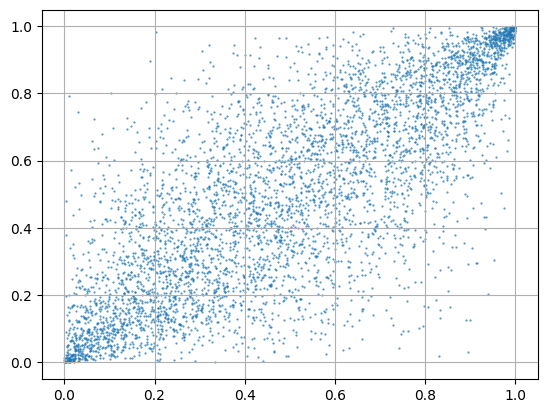

In [6]:
import pyvinecopulib as pv
cop = pv.Bicop(family=pv.BicopFamily.bb1, rotation=0, parameters=[0.3, 2.1])
u = cop.simulate(n=5000, seeds=[1, 2, 3])
print(u)

plt.scatter(u[:,0],u[:,1], s=0.3, alpha=0.8)
plt.grid()

In [8]:
import numpy as np
from scipy.optimize import fsolve

# Given value of t
t_given = 0.5  # Example value, adjust as needed

# Define the function to solve, representing the equation t = 1 - 2/(b(a+2))
# This function will return 0 when the equation is satisfied.
def equations(vars):
    a, b = vars  # unpack the variables
    t_calculated = 1 - 2 / (b * (a + 2))
    return t_calculated - t_given

# Initial guesses for a and b
initial_guess = [1.0, 1.0]

# Use fsolve to solve the system of equations
solution = fsolve(equations, initial_guess)

# Extract the solution
a_solution, b_solution = solution

# Print the results
print(f"Approximated a: {a_solution}")
print(f"Approximated b: {b_solution}")

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument '_wrapped_func'.Shape should be (2,) but it is (1,).

In [30]:
from scipy.optimize import fsolve

def tau2par_0(tau: float) -> tuple:
        
    def func(par):
        return [(1 - 2 / (par[1] * (par[0] + 2))) - tau, par[1] - 1.5]
        
    root = fsolve(func, [0.1, 2])
        
    return root

def par2tau_0(par: tuple) -> float:
    return 1 - 2 / (par[1] * (par[0] + 2))

tau = par2tau_0([0.3, 2.1])

print(tau)

tau2par_0(tau)

0.5859213250517599


array([0.1977261, 2.1977261])

tensor([0.4751, 0.5788, 0.9507,  ..., 0.8485, 0.7434, 0.3273],
       dtype=torch.float64) tensor([0.5271, 0.1602, 0.9716,  ..., 0.7793, 0.7601, 0.2127],
       dtype=torch.float64)


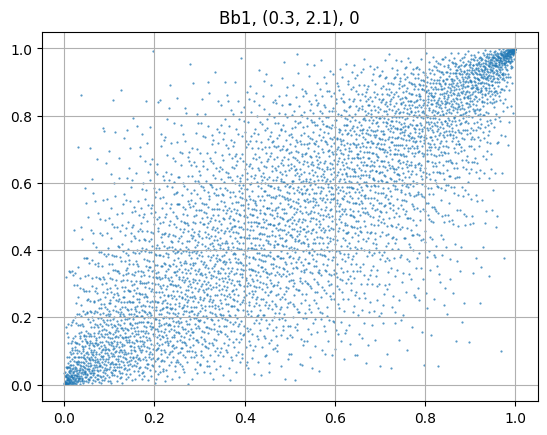

In [5]:
# simulate from a bcp with given family, parameter, rotation
fam, par, rot = "Bb1", (0.3, 2.1), 0
V_bcp = tvc.bicop.DataBiCop(fam=fam, par=par, rot=rot).sim(
    num_sim=5000, device=DEVICE, seed=0, is_sobol=True
)
# visualization
plt.scatter(*V_bcp.T.cpu(), s=0.3, alpha=0.8)
print(*V_bcp.T.cpu())
plt.title(f"{fam}, {par}, {rot}")
plt.grid()

## factory function


DataBiCop(fam='Independent', negloglik=0.0, num_obs=5000, par=(), rot=0)

{'fam': 'Independent',
 'rot': 0,
 'tau': 0.0,
 'par': (),
 'num_obs': 5_000,
 'negloglik': 0.0,
 'aic': 0.0,
 'bic': 0.0}


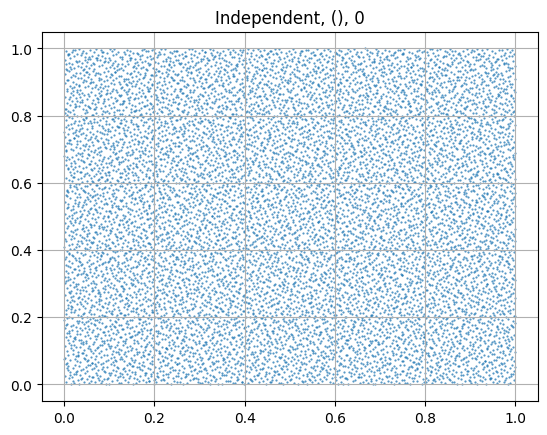

In [14]:
# make a DataBiCop object (from fitting the bicop obs);
mdl_bcp = tvc.bicop.bcp_from_obs(V_bcp)
display(mdl_bcp)
print(mdl_bcp)
# use the fitted model to simulation;
V_bcp = mdl_bcp.sim(num_sim=10000, device=DEVICE, seed=1, is_sobol=True)
# visualization
plt.scatter(*V_bcp.T.cpu(), s=0.3, alpha=0.8)
plt.title(f"{mdl_bcp.fam}, {mdl_bcp.par}, {mdl_bcp.rot}")
plt.grid()

## dataclass methods

In [15]:
lst_mtd = [_ for _ in dir(mdl_bcp) if not _.startswith("_")]
print(lst_mtd)
for _ in ("cdf", "hfunc1", "hfunc2", "hinv1", "hinv2", "l_pdf"):
    print(f"{_}\t{mdl_bcp.__getattribute__(_)(V_bcp)}")

['aic', 'bic', 'cdf', 'fam', 'hfunc1', 'hfunc2', 'hinv1', 'hinv2', 'l_pdf', 'negloglik', 'num_obs', 'num_par', 'par', 'rot', 'sim', 'tau']
cdf	tensor([[0.0969],
        [0.8365],
        [0.0829],
        ...,
        [0.5540],
        [0.0615],
        [0.2251]], dtype=torch.float64)
hfunc1	tensor([[0.3618],
        [0.9918],
        [0.1275],
        ...,
        [0.7890],
        [0.0810],
        [0.7100]], dtype=torch.float64)
hfunc2	tensor([[0.2677],
        [0.8434],
        [0.6499],
        ...,
        [0.7022],
        [0.7589],
        [0.3170]], dtype=torch.float64)
hinv1	tensor([[0.3618],
        [0.9918],
        [0.1275],
        ...,
        [0.7890],
        [0.0810],
        [0.7100]], dtype=torch.float64)
hinv2	tensor([[0.2677],
        [0.8434],
        [0.6499],
        ...,
        [0.7022],
        [0.7589],
        [0.3170]], dtype=torch.float64)
l_pdf	tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], dtype=torch.